In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'new-plant-diseases-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F78313%2F182633%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T092317Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D976e56f268bd26663dd73a013754db1a3d024077c2a01780799bf722c1ea05104c246ede374f137dcae7cdddbd04e606759552c45d4ee40e0ecc4177992eb51df8e5be61467fd90ae2d4bb5325c05ed9de6a359ffdf7527783562950a2b843473f456f742af1197c5cc130ac26a74ecb91d85191f6f77c434e7c34459dd116c44a84c11b3286a9e772885c829dd814782622d442fcc84b832106f71d5d2da4cdd3a46fab8d4b4935ea0189cd8c183cebc9e4d2c1b09fd1902db71bf6ba1ceeeecbb1ddf20068b17386354bd1cf60e58091b9a6e9e0809d5dc5143d716ec93f6a87bd1d01756e83a5700e9091b6f787c49970ecfe285c2f2a53a58d1e04325378'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2897709187 bytes downloaded
Downloaded and uncompressed: new-plant-diseases-dataset
Data source import complete.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Libraries

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# 2. Define Paths

In [4]:
train_source = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'  # Train folder
valid_source = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'  # Valid folder
test_source = '/kaggle/input/new-plant-diseases-dataset/test/test'  # Test folder

combined_folder = '/kaggle/working/combined'  # Folder to combine train, valid, and test images
output_folder = '/kaggle/working/output'  # Final output folder for train, valid, test splits

train_folder = os.path.join(output_folder, 'train')
valid_folder = os.path.join(output_folder, 'valid')
test_folder= os.path.join(output_folder, 'test')

# Create necessary directories
os.makedirs(combined_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# 3. Get class labels from the train folder

In [5]:
class_labels = [f for f in os.listdir(train_source) if os.path.isdir(os.path.join(train_source, f))]
print("Class labels:", class_labels)

Class labels: ['Apple___Black_rot', 'Peach___healthy', 'Tomato___Early_blight', 'Tomato___Tomato_mosaic_virus', 'Tomato___Bacterial_spot', 'Apple___healthy', 'Apple___Cedar_apple_rust', 'Apple___Apple_scab', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Cherry_(including_sour)___healthy', 'Blueberry___healthy', 'Corn_(maize)___Common_rust_', 'Squash___Powdery_mildew', 'Pepper,_bell___healthy', 'Strawberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Northern_Leaf_Blight', 'Orange___Haunglongbing_(Citrus_greening)', 'Grape___Esca_(Black_Measles)', 'Peach___Bacterial_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Strawberry___Leaf_scorch', 'Tomato___Late_blight', 'Potato___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___healthy', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___healthy', 'Pepper,_bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Raspberry___health

# 4. Copy train and valid images to the combined folder

In [6]:
def copy_images(source_folder, destination_folder):
    for class_name in class_labels:
        class_source_folder = os.path.join(source_folder, class_name)
        class_dest_folder = os.path.join(destination_folder, class_name)
        os.makedirs(class_dest_folder, exist_ok=True)

        images = [img for img in os.listdir(class_source_folder) if os.path.isfile(os.path.join(class_source_folder, img))]
        for image in images:
            src_image_path = os.path.join(class_source_folder, image)
            dest_image_path = os.path.join(class_dest_folder, image)
            shutil.copy(src_image_path, dest_image_path)


# Copy train and valid images to the combined folder
copy_images(train_source, combined_folder)
copy_images(valid_source, combined_folder)

# 5. Organize Test Images into the combined folder based on class label

In [7]:
# Mapping of image name patterns to class names
class_mapping = {
    "AppleCedarRust": "Apple___Cedar_apple_rust",
    "AppleScab": "Apple___Apple_scab",
    "CornCommonRust": "Corn_(maize)___Common_rust_",
    "PotatoEarlyBlight": "Potato___Early_blight",
    "PotatoHealthy": "Potato___healthy",
    "TomatoEarlyBlight": "Tomato___Early_blight",
    "TomatoHealthy": "Tomato___healthy",
    "TomatoYellowCurlVirus": "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
}

test_images = [img for img in os.listdir(test_source) if os.path.isfile(os.path.join(test_source, img))]

# Loop through test images and copy them to the appropriate class folder in combined_folder
for image in test_images:
    matched = False
    for pattern, class_name in class_mapping.items():
        if pattern in image:  # Check if the image filename contains the pattern
            class_folder = os.path.join(combined_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)

            src_image_path = os.path.join(test_source, image)
            dest_image_path = os.path.join(class_folder, image)
            shutil.copy(src_image_path, dest_image_path)
            matched = True
            break

    if not matched:
        print(f"Warning: No match found for image {image}")

print("Test images have been successfully added to the combined folder!")


Test images have been successfully added to the combined folder!


# 6. Split into 60% Train, 20% Valid, and 20% Test

In [8]:
for class_name in class_labels:
    class_path = os.path.join(combined_folder, class_name)
    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    # Shuffle images for random distribution
    random.shuffle(images)

    # Calculate split indices
    total_images = len(images)
    train_count = int(total_images * 0.6)
    valid_count = int(total_images * 0.2)

    # Split the images
    train_images = images[:train_count]
    valid_images = images[train_count:train_count + valid_count]
    test_images = images[train_count + valid_count:]

    # Function to move images to the respective folder
    def move_images(image_list, destination_folder):
        dest_class_folder = os.path.join(destination_folder, class_name)
        os.makedirs(dest_class_folder, exist_ok=True)
        for image in image_list:
            src_image_path = os.path.join(class_path, image)
            dest_image_path = os.path.join(dest_class_folder, image)
            shutil.copy(src_image_path, dest_image_path)  # Copy instead of move
            # print(f"Copied {image} to {dest_class_folder}")

    # Move images to train, valid, and test folders
    move_images(train_images, train_folder)
    move_images(valid_images, valid_folder)
    move_images(test_images, test_folder)

print("Images have been successfully split into train, valid, and test sets!")

# Function to count and display the total number of images in each class folder
def count_images_in_folder(folder):
    class_folders = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

    print(f"\nTotal images in '{folder}' folder:")
    for class_name in class_folders:
        class_path = os.path.join(folder, class_name)
        num_images = len([img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))])
        print(f"Class: {class_name} - Total Images: {num_images}")

# Count and display images for train, valid, and test sets
count_images_in_folder(train_folder)
count_images_in_folder(valid_folder)
count_images_in_folder(test_folder)

print("Images have been successfully split into train, valid, and test sets!")


Images have been successfully split into train, valid, and test sets!

Total images in '/kaggle/working/output/train' folder:
Class: Apple___Black_rot - Total Images: 1490
Class: Peach___healthy - Total Images: 1296
Class: Tomato___Early_blight - Total Images: 1443
Class: Tomato___Tomato_mosaic_virus - Total Images: 1342
Class: Tomato___Bacterial_spot - Total Images: 1276
Class: Apple___healthy - Total Images: 1506
Class: Apple___Cedar_apple_rust - Total Images: 1322
Class: Apple___Apple_scab - Total Images: 1513
Class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) - Total Images: 1291
Class: Cherry_(including_sour)___healthy - Total Images: 1369
Class: Blueberry___healthy - Total Images: 1362
Class: Corn_(maize)___Common_rust_ - Total Images: 1432
Class: Squash___Powdery_mildew - Total Images: 1302
Class: Pepper,_bell___healthy - Total Images: 1491
Class: Strawberry___healthy - Total Images: 1368
Class: Cherry_(including_sour)___Powdery_mildew - Total Images: 1262
Class: Corn_(maize)___N

# 7. Define Image Size and Batch Size

In [9]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCH = 30

# 8. Load the VGG16 pre-trained model without the top layer

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the base_model so its weights are not updated during training
base_model.trainable = False

print(base_model.output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_174>


# 9. Add custom layers on top of VGG16

In [11]:
x = base_model.output
x = Flatten()(x)  # Flatten the output from the convolutional layers
x = Dense(2048, activation='relu')(x)  # Fully connected layer
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.4)(x)  # Dropout to prevent overfitting

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.1)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # Adding batch normalization
x = Dropout(0.1)(x)

output = Dense(38, activation='sigmoid')(x)

# 10. Create the final model

In [12]:
model = Model(inputs=base_model.input, outputs=output)

# 11. Set the layers of the pre-trained model to be non-trainable

In [13]:
# Unfreeze only the last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = True
# There are 175 layers

# 12. Compile the model

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 13. Set up data generators

In [15]:
# Train Data Generator with Image Augmentation and Color Correction
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Milder rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,  # Reduced shear
    zoom_range=0.1,  # Reduced zoom
    horizontal_flip=True,  # Horizontal flip
    brightness_range=[0.9, 1.1],  # Mild brightness adjustment
    fill_mode='nearest',
)

# Validation Data Generator (No Augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Test Data Generator (No Augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train Generator
train_generator = train_datagen.flow_from_directory(
    train_folder,  # Path to your train folder
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation Generator
valid_generator = valid_datagen.flow_from_directory(
    valid_folder,  # Path to your validation folder
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test Generator
test_generator = test_datagen.flow_from_directory(
    test_folder,  # Path to your test folder
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important: No shuffling in the test set
)

Found 52728 images belonging to 38 classes.
Found 17566 images belonging to 38 classes.
Found 17606 images belonging to 38 classes.


# 14. Early Stopping and Learning Rate Reduction

In [16]:
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/ML_JU_Project/Combine_Plant/plant_ResNet50_model_Sigmoid_Combine.weights.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1)

# 15. Train the model

In [17]:
history = model.fit(
    train_generator,
    epochs=EPOCH,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1648/1648 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.6395 - loss: 1.4342
Epoch 1: val_loss improved from inf to 0.05217, saving model to /content/drive/MyDrive/ML_JU_Project/Combine_Plant/plant_ResNet50_model_Sigmoid_Combine.weights.h5
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 1349s 764ms/step - accuracy: 0.6396 - loss: 1.4337 - val_accuracy: 0.9846 - val_loss: 0.0522 - learning_rate: 1.0000e-04
Epoch 2/30
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9604 - loss: 0.1570
Epoch 2: val_loss did not improve from 0.05217
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 1226s 741ms/step - accuracy: 0.9604 - loss: 0.1570 - val_accuracy: 0.9717 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 3/30
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.9712 - loss: 0.1096
Epoch 3: val_loss did not improve from 0.05217
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 1189s 720ms/step - accuracy: 0.9712 - loss: 0.1096 - val_accuracy: 0.9810 - val_loss: 0.0659 - learning_rate: 1.0000e-04
Epoch 4/30
1648/1648 ━━━━━━━

# 16. Evaluate the model on the test set

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test loss (initial): {test_loss}")
print(f"Test Accuracy: {test_acc}")

551/551 ━━━━━━━━━━━━━━━━━━━━ 63s 113ms/step - accuracy: 0.9865 - loss: 0.0449
Test loss (initial): 0.056976065039634705
Test Accuracy: 0.9831307530403137


# 17. Get Confusion Matrix and Classification Report

551/551 ━━━━━━━━━━━━━━━━━━━━ 58s 98ms/step


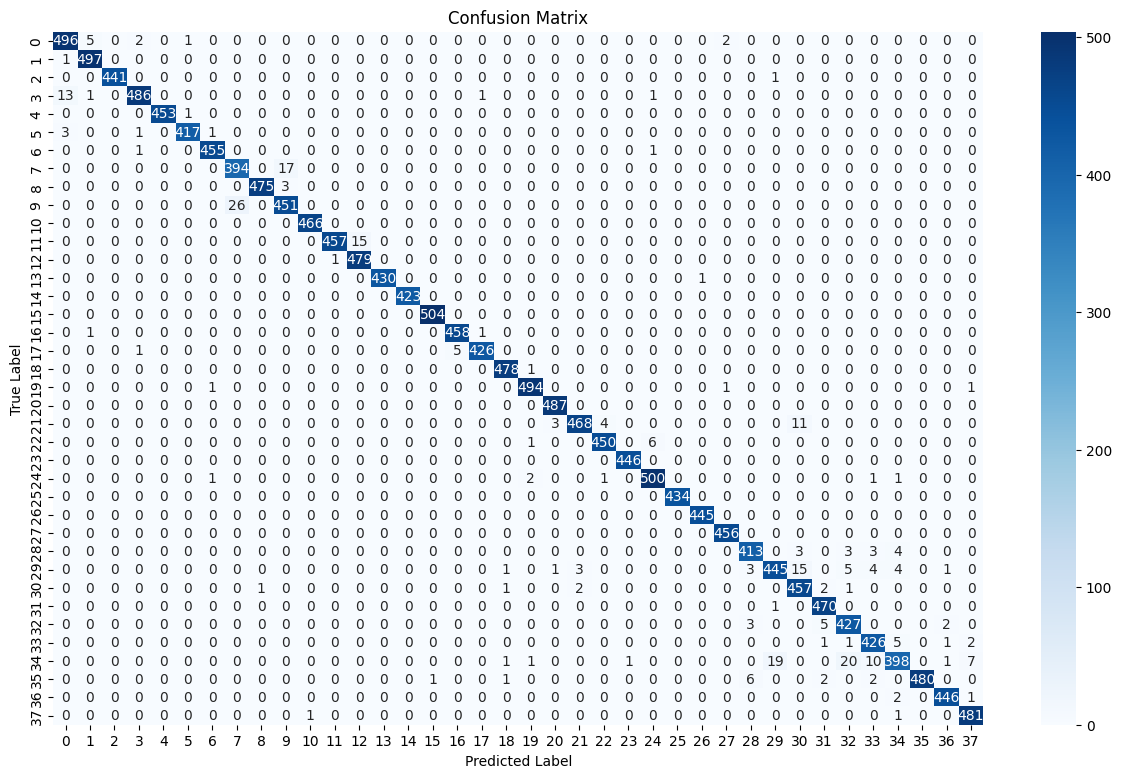

In [19]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

In [20]:
# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)

Classification Report:
                                                     precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.98      0.97       506
                                 Apple___Black_rot       0.99      1.00      0.99       498
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       442
                                   Apple___healthy       0.99      0.97      0.98       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       422
                 Cherry_(including_sour)___healthy       0.99      1.00      0.99       457
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.96      0.95       411
                       Corn_(maize)___Common_rust_       1.00      0.99      1.00       478
               Corn_(maize)___Northern_Leaf_Blight     